Import required libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("data/FIFA_World_Cup_Tidy.csv")

Encoding the continent column into dummy variables

In [3]:
df_encoded = pd.get_dummies(df, columns = ['continent'])

In [4]:
df_encoded

,season,team,players_used,age,matches_played,starts,minutes,90s_played,goals,goals_minus_penalty,...,yellow_cards,red_cards,goals_per_90,goals_minus_penalty_per_90,world_cup_winner,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
0,1930,Argentina,21,24.3,5,55,450,5.0,18,18,...,0,0,3.60,3.60,0,False,True,False,False,False
1,1930,Belgium,13,23.4,2,22,180,2.0,0,0,...,0,0,0.00,0.00,0,False,False,False,True,False
2,1930,Bolivia,13,24.3,2,22,180,2.0,0,0,...,0,0,0.00,0.00,0,False,True,False,False,False
3,1930,Brazil,17,24.2,2,22,180,2.0,5,5,...,0,0,2.50,2.50,0,False,True,False,False,False
4,1930,Chile,16,25.7,3,33,270,3.0,4,4,...,0,0,1.33,1.33,0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2022,Spain,21,25.5,4,44,390,4.3,9,8,...,2,0,2.08,1.85,0,False,False,False,True,False
460,2022,Switzerland,24,27.6,4,44,360,4.0,5,5,...,9,0,1.25,1.25,0,False,False,False,True,False
461,2022,Tunisia,21,26.9,3,33,270,3.0,1,1,...,5,0,0.33,0.33,0,True,False,False,False,False
462,2022,United States,20,24.5,4,44,360,4.0,3,3,...,5,0,0.75,0.75,0,False,True,False,False,False


# Correlation Matrix

world_cup_winner              1.000000
goals                         0.428014
goals_minus_penalty           0.424845
starts                        0.348902
matches_played                0.347936
90s_played                    0.345396
minutes                       0.344802
goals_per_90                  0.295001
goals_minus_penalty_per_90    0.293252
penalty_goals                 0.157504
continent_Americas            0.081596
age                           0.027625
continent_Europe              0.019320
yellow_cards                  0.017833
players_used                  0.008463
continent_Oceania            -0.029550
red_cards                    -0.038970
continent_Asia               -0.069458
season                       -0.073116
continent_Africa             -0.075783
Name: world_cup_winner, dtype: float64


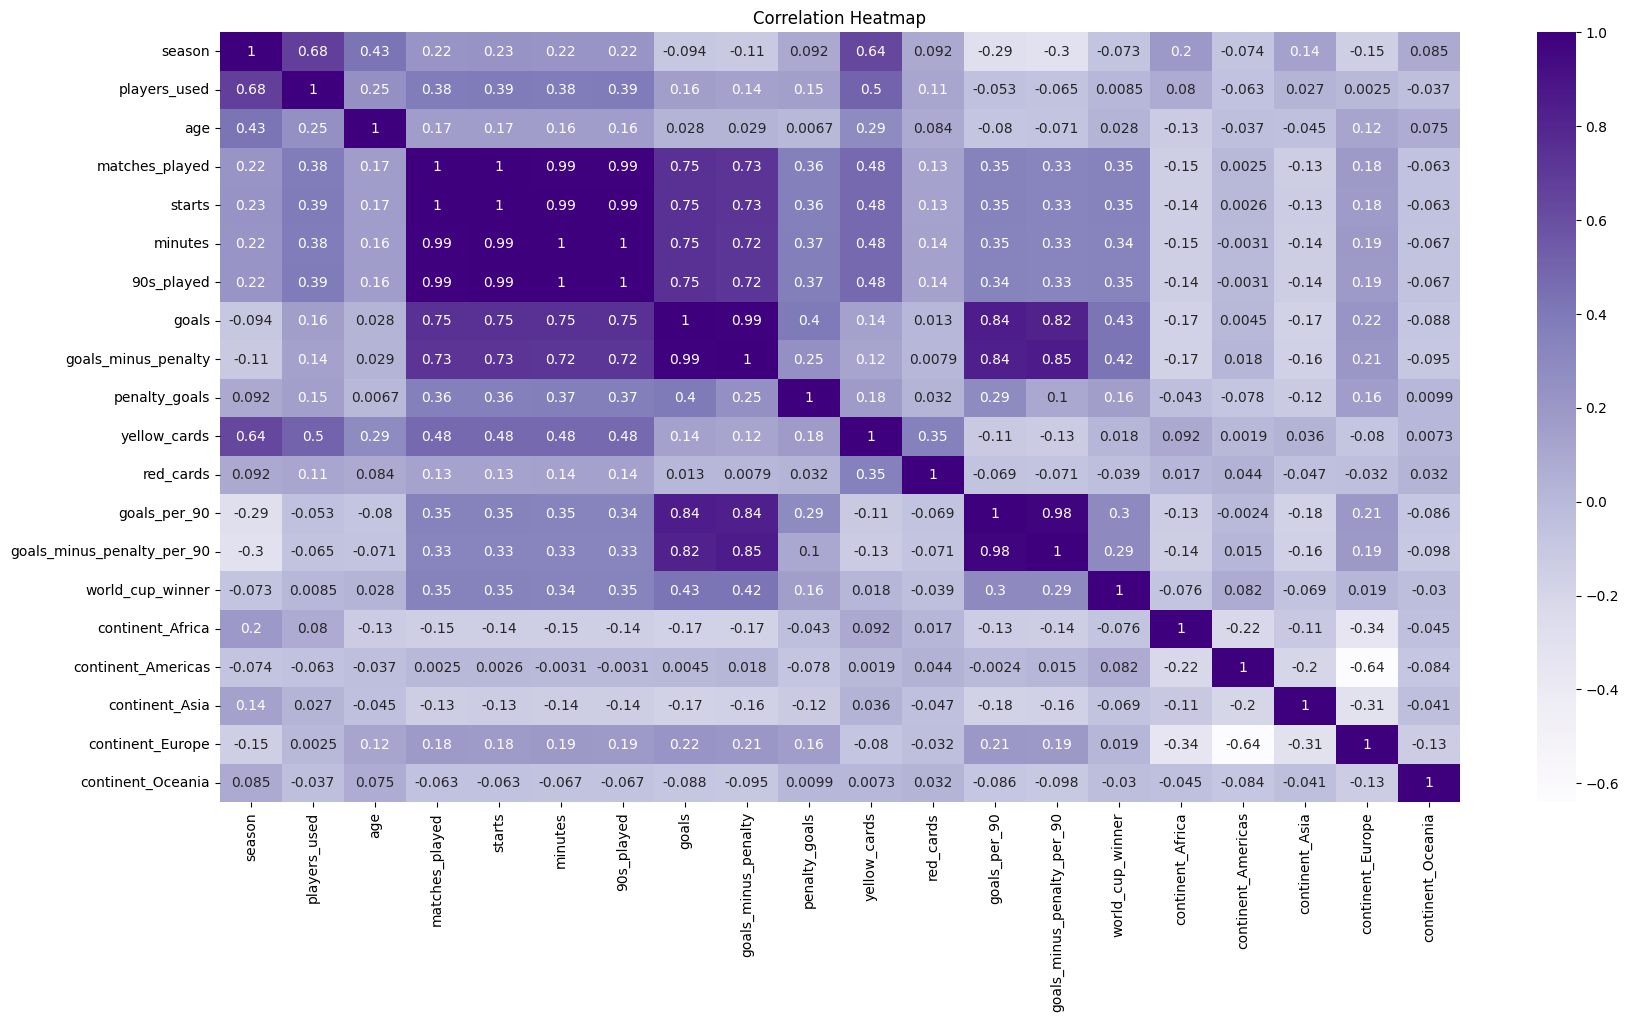

In [5]:
corr = df_encoded.corr(numeric_only=True)

# Focus on correlation with 'world_cup_winner'
target_corr = corr['world_cup_winner'].sort_values(ascending=False)
print(target_corr)

# Visualize
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='Purples')
plt.title('Correlation Heatmap')
plt.show()

# Testing Multicollinearity

Exclude non-numeric features

In [6]:
X = df_encoded.drop(columns=['world_cup_winner', 'team', 'season'])

Calculate VIF

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

                       Feature           VIF
0                 players_used  1.471838e+00
1                          age  1.183676e+00
2               matches_played  7.238234e+02
3                       starts  7.814852e+02
4                      minutes  1.103189e+04
5                   90s_played  1.116350e+04
6                        goals           inf
7          goals_minus_penalty           inf
8                penalty_goals           inf
9                 yellow_cards  2.075879e+00
10                   red_cards  1.166902e+00
11                goals_per_90  1.534092e+02
12  goals_minus_penalty_per_90  1.601189e+02
13            continent_Africa           inf
14          continent_Americas           inf
15              continent_Asia           inf
16            continent_Europe           inf
17           continent_Oceania           inf


c:\Users\Sydney\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Picking which to drop in regards to correlation with target (world_cup_winner)

In [8]:
df_encoded.columns

Index(['season', 'team', 'players_used', 'age', 'matches_played', 'starts',
       'minutes', '90s_played', 'goals', 'goals_minus_penalty',
       'penalty_goals', 'yellow_cards', 'red_cards', 'goals_per_90',
       'goals_minus_penalty_per_90', 'world_cup_winner', 'continent_Africa',
       'continent_Americas', 'continent_Asia', 'continent_Europe',
       'continent_Oceania'],
      dtype='object')

In [9]:
print(f"Correlation world_cup_winner - Goals: {df_encoded['world_cup_winner'].corr(df_encoded['goals'])}")
print(f"Correlation world_cup_winner - Goals per 90: {df_encoded['world_cup_winner'].corr(df_encoded['goals_per_90'])}")


Correlation world_cup_winner - Goals: 0.42801366367516086
Correlation world_cup_winner - Goals per 90: 0.2950013423866741


Drop columns

In [10]:
df_cleaned = df_encoded.drop(columns = ['goals_minus_penalty','penalty_goals', 'starts','minutes','90s_played','goals_minus_penalty_per_90','goals_per_90'])

Calculate VIF again

In [11]:
X = df_cleaned.drop(columns=['world_cup_winner', 'team', 'season'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

               Feature       VIF
0         players_used  1.446394
1                  age  1.170556
2       matches_played  3.536121
3                goals  2.687037
4         yellow_cards  2.023864
5            red_cards  1.159666
6     continent_Africa       inf
7   continent_Americas       inf
8       continent_Asia       inf
9     continent_Europe       inf
10   continent_Oceania       inf


c:\Users\Sydney\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [12]:
df_cleaned.columns

Index(['season', 'team', 'players_used', 'age', 'matches_played', 'goals',
       'yellow_cards', 'red_cards', 'world_cup_winner', 'continent_Africa',
       'continent_Americas', 'continent_Asia', 'continent_Europe',
       'continent_Oceania'],
      dtype='object')

# Train and Test

In [13]:
X = df_cleaned.drop(columns=['world_cup_winner', 'team', 'season'])
y = df_cleaned['world_cup_winner']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [15]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, class_weight='balanced')
)

In [16]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [17]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [18]:
print("Classification Report:\n", classification_report(y_test, y_pred), "\n")
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Baseline accuracy score:", len(y[y == 0]) / len(y))
print("Cohen’s Kappa score", cohen_kappa_score(y_test, y_pred))
print("ROC-AUC score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92        86
           1       0.33      0.86      0.48         7

    accuracy                           0.86        93
   macro avg       0.66      0.86      0.70        93
weighted avg       0.94      0.86      0.89        93
 

Accuracy score: 0.8602150537634409
Baseline accuracy score: 0.9525862068965517
Cohen’s Kappa score 0.41678726483357453
ROC-AUC score: 0.8970099667774086


Plot feature importance

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.named_steps['logisticregression'].coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)

               Feature  Coefficient
2       matches_played     2.177916
3                goals     1.129169
9     continent_Europe     0.259123
7   continent_Americas     0.238695
10   continent_Oceania    -0.051678
6     continent_Africa    -0.219132
4         yellow_cards    -0.308561
1                  age    -0.411951
5            red_cards    -0.450948
8       continent_Asia    -0.550713
0         players_used    -0.981418


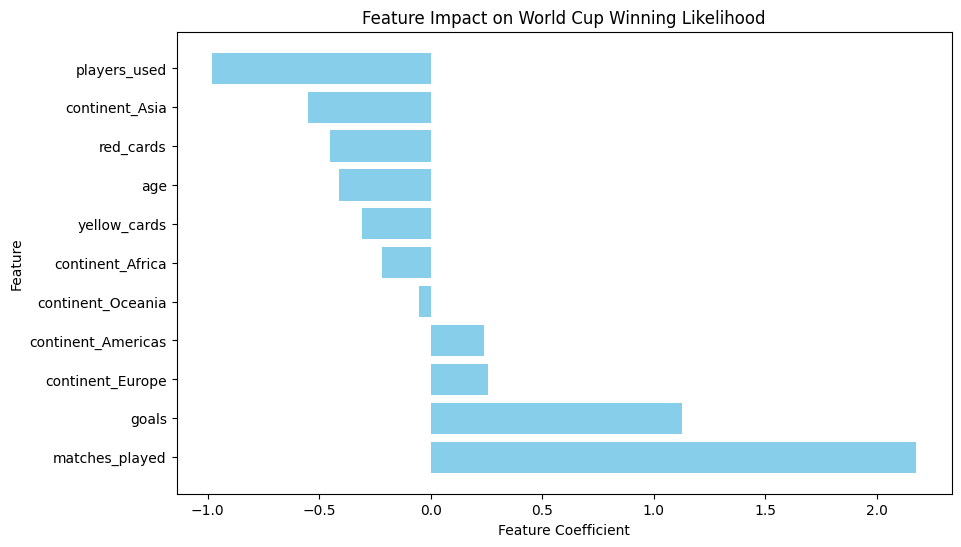

In [20]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Feature Coefficient')
plt.ylabel('Feature')
plt.title('Feature Impact on World Cup Winning Likelihood')
plt.show()